In [1]:
using Pkg

In [2]:
Pkg.add("MAT")
Pkg.add("Glob")
Pkg.add("StatsBase")
Pkg.add("Random")
Pkg.add("MLDataUtils")
Pkg.add("Turing")
Pkg.add("Distributions")
Pkg.add("StatsPlots")
using MAT, Glob, StatsBase, Random, MLDataUtils, Turing, Distributions, StatsPlots

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
Precompiling project...
    389.3 ms  ✓ ColorVectorSpace → SpecialFunctionsExt
    387.0 ms  ✓ LearnBase
    575.6 ms  ✓ Interpolations → InterpolationsUnitfulExt
    777.9 ms  ✓ MultivariateStats
    811.1 ms  ✓ Clustering
   1075.6 ms  ? SciMLBase
    687.4 ms  ✓ MLLabelUtils
    746.8 ms  ✓ MLDataPattern
    893.4 ms  ✓ MLDataUtils
   3218.0 ms  ? Turing
   3152.7 ms  ? Turing → TuringOptimExt
  18391.5 ms  ✓ Plots
   1952.4 ms  ✓ Plots → UnitfulExt
   2073.7 ms  ✓ Plots → IJuliaExt
   2763.1 ms  ✓ StatsPlots
  12 dependencies successfully precompiled in 24 seconds. 431 already precompiled.
  3 dependencies failed but may be precompilable after restarting julia
  3 dependencies had output during precompilation:
┌ SciMLBase
│  WARNING: Method definition islinear(Any) in module SciMLOperators at /Users/keyshavmor/.julia/packages/SciMLO

In [3]:
# sub-MOA101, sub-MOA102, sub-MOA104, sub-MOA105, sub-MOA107, sub-MOA108, sub-MOA109, sub-MOA110, sub-MOA111, sub-MOA112, sub-MOA114,
# sub-MOA115, sub-MOA116, sub-MOA118, sub-MOA121, sub-MOA122, sub-MOA123, sub-MOA124, sub-MOA126, sub-MOA127, sub-MOA128, sub-MOA130,
# sub-MOA131, sub-MOA133, sub-MOA134, sub-MOA135, sub-MOA301, sub-MOA302, sub-MOA303, sub-MOA304, sub-MOA305, sub-MOA306, sub-MOA307,
# sub-MOA309, sub-MOA312, sub-MOA314, sub-MOA315, sub-MOA317, sub-MOA319, sub-MOA320, sub-MOA321, sub-MOA325, sub-MOA327

# These are absolute d2 MADRS values. THESE ARE NOT MADRS difference values
y = (24,22,17,34,21,41,18,29,0,5,31,22,22,5,26,37,27,36,9,20,25,29,29,32,17,37)

mean_y = mean(y)
var_y  = var(y)   # sample variance by default (divides by n-1)
std_y = sqrt(var_y)

10.514532068303591

In [4]:
# List of subjects that have some degree of depression
target_subjects = [
    "sub-MOA101", "sub-MOA102", "sub-MOA104", "sub-MOA105", "sub-MOA107", "sub-MOA108", "sub-MOA109", "sub-MOA110", "sub-MOA111",
    "sub-MOA112", "sub-MOA114", "sub-MOA115", "sub-MOA116", "sub-MOA118", "sub-MOA121", "sub-MOA122", "sub-MOA123","sub-MOA124", 
    "sub-MOA126", "sub-MOA127", "sub-MOA128", "sub-MOA130", "sub-MOA131", "sub-MOA133", "sub-MOA134", "sub-MOA135"]

# Base path to your subject folders
base_path = "Spectral_DCM_Collection_DMN"

# Collect valid file paths
valid_files = String[]

for subj in target_subjects
    subj_path = joinpath(base_path, subj)
    ses_path = joinpath(subj_path, "ses-b0")
    glm_path = joinpath(ses_path, "glm")
    dcm_file = joinpath(glm_path, "spDCM_DMN.mat")

    if !isdir(ses_path)
        @warn "Missing session folder: $ses_path"
    elseif !isfile(dcm_file)
        @warn "Missing spDCM_DMN.mat for $subj"
    else
        push!(valid_files, dcm_file)
    end
end

println("✅ Found Spectral_DCM.mat for $(length(valid_files)) out of $(length(target_subjects)) subjects.")


✅ Found Spectral_DCM.mat for 26 out of 26 subjects.


In [5]:
# Extract A matrix features as a flat 16-element vector
function extract_features(file)
    mat = matread(file)
    A = mat["params"]  # 4×4 matrix
    return vec(Matrix(A))  # Flatten to 16-element vector
end

extract_features (generic function with 1 method)

In [6]:
b0_MADRS = (35, 31, 41, 36, 38, 33, 25, 31, 30, 35, 37, 26, 34, 33, 25, 30, 30, 35, 24, 32, 33, 38, 28, 34, 35, 40)
# Create feature dataset
X = hcat([extract_features(file) for file in valid_files]...)'
# Convert b0_MADRS to a column vector
b0_vec = reshape(collect(b0_MADRS), :, 1)  # ensures it becomes a (n_subjects × 1) matrix

# Add it as the 13th feature (column) to X
X = hcat(X, b0_vec)

26×17 Matrix{Float64}:
  0.151692    0.0907573    0.389568    …   0.0929935   -0.993028   35.0
  0.289875    0.265534     0.229561       -1.53029     -0.922448   31.0
  0.335402   -0.338222     0.155971       -0.00771969   0.422774   41.0
 -0.48944     0.72979      0.317908       -0.229136     0.0617672  36.0
  0.269022   -0.10133      0.00906378     -0.826917    -0.384761   38.0
 -0.150948    0.311525     0.804322    …   0.00552686  -0.536396   33.0
 -0.176607    0.396345     0.565983        0.11167     -0.909281   25.0
 -0.152973    0.114295     0.593936       -0.0496335   -0.32027    31.0
  0.646848    0.15497      0.217254       -0.15346     -0.0174001  30.0
  0.614897    0.0562123    0.0821744       0.0730572    0.120639   35.0
 -0.285144    0.467923     0.24683     …   0.405207    -0.388709   37.0
 -0.216906    0.415341     0.200254       -0.0739059   -0.488306   26.0
  0.0172093   0.407766     0.400303       -0.16168     -0.148212   34.0
  0.232184    0.816172     0.235925      

In [7]:
# Assume: X is a matrix (n_samples × n_features), y is a vector (n_samples)
n_samples = size(X, 1)
idx = shuffle(1:n_samples)

# 80-20 split
n_train = round(Int, 0.8 * n_samples)
train_idx = idx[1:n_train]
test_idx  = idx[n_train+1:end]

# Create splits
X_train = X[train_idx, :]
y_train = y[train_idx]

X_test  = X[test_idx, :]
y_test  = y[test_idx]

(34, 17, 36, 29, 9)

In [9]:
# Step 1: Compute mean and std *from training set only*
x_mean = mean(X_train, dims=1)
x_std  = std(X_train, dims=1)

# Step 2: Normalize train and test using training stats
X_train_std = (X_train .- x_mean) ./ x_std
X_test_std  = (X_test  .- x_mean) ./ x_std

y_mean = mean(y_train)
y_std  = std(y_train)

y_train_std = (y_train .- y_mean) ./ y_std
y_test_std  = (y_test .- y_mean) ./ y_std  # use train mean/std only!

y_train_std = collect(y_train_std)

y_test_std = collect(y_test_std)

5-element Vector{Float64}:
  1.013653529478689
 -0.6018567831279714
  1.2037135662559433
  0.5385034375355536
 -1.3620969302369883

In [10]:
using LinearAlgebra
Pkg.add("StatsFuns")
using StatsFuns

@model function bayesian_linear_regression(X, y)
    n, d = size(X)
    # hierarchical shrinkage
    τ ~ truncated(Cauchy(0, 1), 0, Inf)
    w ~ MvNormal(zeros(d), τ^2 * I)
    b ~ Normal(0, 10)
    σ ~ truncated(Normal(0, 5), 0, Inf)

    for i in 1:n
        μ = dot(w, X[i, :]) + b
        y[i] ~ Normal(μ, σ)
    end
end

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
Precompiling project...
   1050.2 ms  ? SciMLBase
   2972.5 ms  ? Turing
   3136.0 ms  ? Turing → TuringOptimExt


bayesian_linear_regression (generic function with 2 methods)

In [12]:
Random.seed!(42)
model = bayesian_linear_regression(X_train_std, y_train_std)
chain = sample(model, NUTS(0.90), 100000, chains=4)

┌ Info: Found initial step size
└   ϵ = 0.0125
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:34


Chains MCMC chain (100000×32×1 Array{Float64, 3}):

Iterations        = 1001:1:101000
Number of chains  = 1
Samples per chain = 100000
Wall duration     = 35.87 seconds
Compute duration  = 35.87 seconds
parameters        = τ, w[1], w[2], w[3], w[4], w[5], w[6], w[7], w[8], w[9], w[10], w[11], w[12], w[13], w[14], w[15], w[16], w[17], b, σ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse           ess      rhat  ⋯
      Symbol   Float64   Float64    Float64   Float64       Float64   Float64  ⋯

           τ    0.1452    0.0954     0.0003    0.0018     2319.4578    1.0000  ⋯
        w[1]   -0.1645    0.1872     0.0006    0.0024     5403.1991    1.0000  ⋯
        w[2]    0.0169    0.1330     0.0004    0.0005    76102.1751    1.0000  ⋯
        w[3]    0.1181    0.1

In [13]:
function predict_blr(chain, X_test_std)
    d = 17
    n_samples = length(chain[:b])
    n_test = size(X_test_std, 1)

    # Get weight matrix: (n_samples × d)
    w_matrix = hcat([chain[Symbol("w[$i]")] for i in 1:d]...)

    # Bias vector: (n_samples,)
    b_vec = chain[:b]

    # Predict: (n_test × n_samples)
    preds = X_test_std * w_matrix' .+ b_vec'  # Transpose bias to match rows

    # Posterior mean and std across samples
    y_mean = mean(preds, dims=2)
    y_std = std(preds, dims=2)
    return vec(y_mean), vec(y_std)
end

predict_blr (generic function with 1 method)

In [14]:
y_pred_mean, y_pred_std = predict_blr(chain, X_test_std)

([-0.0069154234638840704, -0.16747039315864254, 0.16400870890987923, 0.18740645488927213, -0.34397555143397907], [0.6336802415980967, 0.41137747640208283, 0.6453377352835714, 0.4268726482873781, 0.6246093591903599])

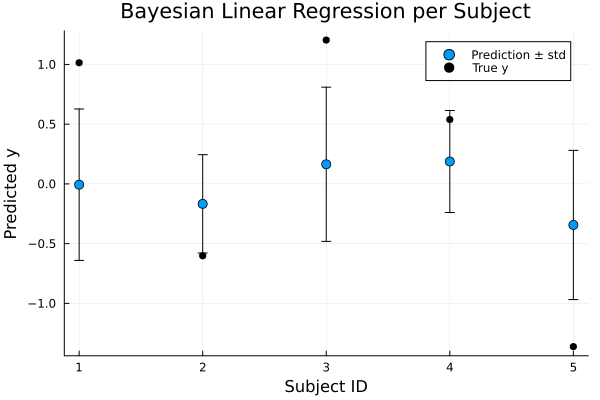

In [15]:
using Plots

n_subjects = length(y_pred_mean)
subject_ids = 1:n_subjects  # X-axis: Subject index (1 to 30)

scatter(
    subject_ids,
    collect(y_pred_mean),
    yerror=collect(y_pred_std),
    xlabel = "Subject ID",
    ylabel = "Predicted y",
    title = "Bayesian Linear Regression per Subject",
    label = "Prediction ± std",
    legend = :topright,
    markersize = 5
)
# Overlay true y values
scatter!(
    subject_ids,
    collect(y_test_std),
    label = "True y",
    color = :black,
    markersize = 4
)


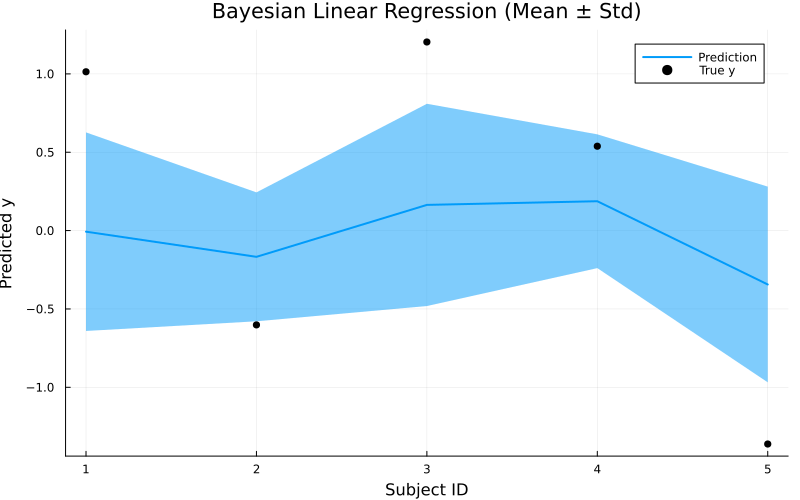

In [16]:
# Plot predicted mean with ± std ribbon
plot(
    subject_ids,
    collect(y_pred_mean),
    ribbon = collect(y_pred_std),
    xlabel = "Subject ID",
    ylabel = "Predicted y",
    title = "Bayesian Linear Regression (Mean ± Std)",
    label = "Prediction",
    linewidth = 2,
    legend = :topright,
    size = (800, 500)  # ⬅️ increased size for better y-axis resolution
)

# Overlay true y values
scatter!(
    subject_ids,
    collect(y_test_std),
    label = "True y",
    color = :black,
    markersize = 4
)

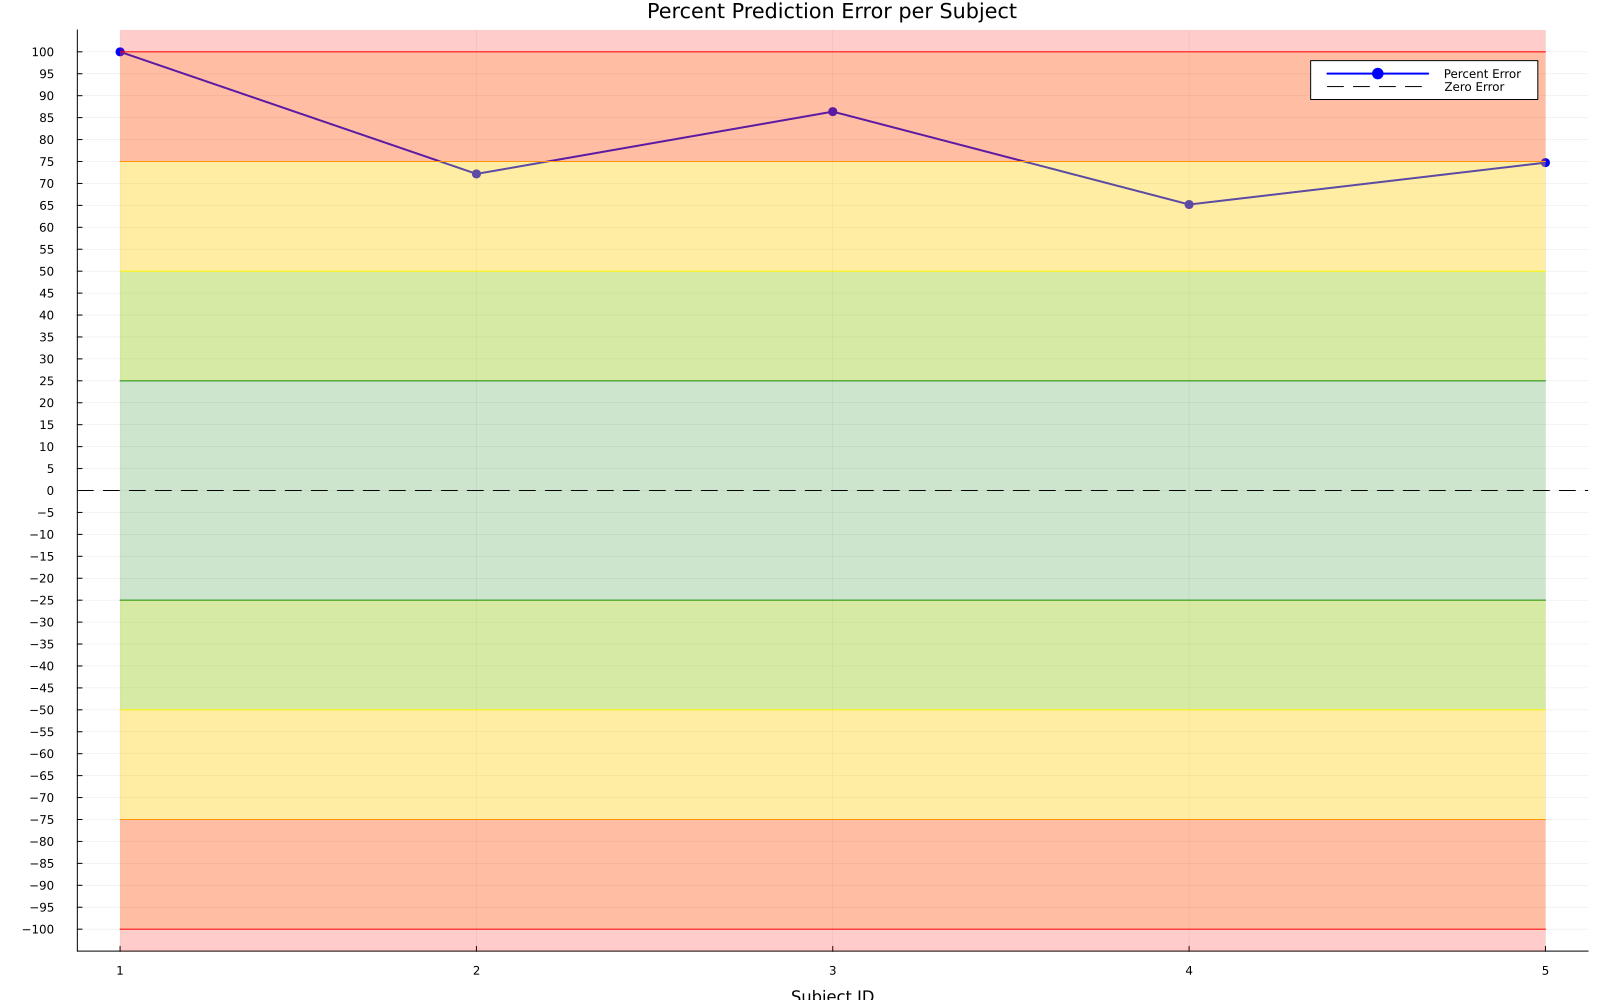

In [17]:
# Step 1: Calculate percent error and cap to ±100%
raw_errors = (collect(y_test_std) .- collect(y_pred_mean)) ./ (collect(y_test_std) .+ eps()) .* 100
residuals = clamp.(raw_errors, -100, 100)  # Cap to ±100%
subject_ids = 1:length(residuals)

# Step 2: Define band edges and matching colors
band_edges = [0, 25, 50, 75, 100]
band_colors = [:green, :yellow, :orange, :red, :purple]

# Step 3: Plot the percent error as a line with markers
plot(
    subject_ids,
    residuals,
    seriestype = :line,
    xlabel = "Subject ID",
    ylabel = "Percent Error (%)",
    title = "Percent Prediction Error per Subject",
    label = "Percent Error",
    legend = :topright,
    color = :blue,
    linewidth = 2,
    markershape = :circle,
    markersize = 5,
    markerstrokewidth = 0,
    size = (1600, 1000),
    ylim = (-105, 105),         # Ensure visibility for ±100% bands
    yticks = -100:5:100         # Y-axis ticks every 5%
)

# Step 4: Add symmetrical error bands
for i in 1:(length(band_edges)-1)
    lo, hi = band_edges[i], band_edges[i+1]
    color = band_colors[i]
    band_x = [1, length(residuals)]

    # Upper band
    plot!(
        band_x,
        fill(hi, 2),
        ribbon = fill(hi - lo, 2),
        fillalpha = 0.2,
        color = color,
        label = ""
    )

    # Lower mirrored band
    plot!(
        band_x,
        fill(-hi, 2),
        ribbon = fill(hi - lo, 2),
        fillalpha = 0.2,
        color = color,
        label = ""
    )
end

# Step 5: Add horizontal zero-error line
hline!([0], linestyle = :dash, color = :black, label = "Zero Error")

In [18]:
 @model function bayesian_quadratic_model(X, y)
    n, d = size(X)

    # Linear and quadratic weights
    w       ~ MvNormal(zeros(d), 1.0)      # linear
    w_quad  ~ MvNormal(zeros(d), 1.0)      # quadratic
    b       ~ Normal(0, 10)
    σ       ~ truncated(Normal(0, 1), 0, Inf)

    for i in 1:n
        x_i = X[i, :]
        x2_i = x_i .^ 2  # elementwise square
        mu = dot(w, x_i) + dot(w_quad, x2_i) + b
        y[i] ~ Normal(mu, σ)
    end
end

bayesian_quadratic_model (generic function with 2 methods)

In [19]:
model = bayesian_quadratic_model(X_train_std, y_train_std)
chain = sample(model, NUTS(0.90), 10000, chain=4)

┌ Info: Found initial step size
└   ϵ = 0.025
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:22


Chains MCMC chain (10000×48×1 Array{Float64, 3}):

Iterations        = 1001:1:11000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 85.69 seconds
Compute duration  = 85.69 seconds
parameters        = w[1], w[2], w[3], w[4], w[5], w[6], w[7], w[8], w[9], w[10], w[11], w[12], w[13], w[14], w[15], w[16], w[17], w_quad[1], w_quad[2], w_quad[3], w_quad[4], w_quad[5], w_quad[6], w_quad[7], w_quad[8], w_quad[9], w_quad[10], w_quad[11], w_quad[12], w_quad[13], w_quad[14], w_quad[15], w_quad[16], w_quad[17], b, σ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse          ess      rhat   ⋯
      Symbol   Float64   Float64    Float64   Float64      Float64   Float64   ⋯

        w[1]   -0.2821    0.7793     0.0078    0.0075   11078.1272    1.0000   ⋯
  

In [20]:
function predict_quadratic(chain, X)
    d = size(X, 2)
    n_samples = length(chain[:b])
    n_test = size(X, 1)

    # Extract weights: shape (n_samples, d)
    w      = hcat([chain[Symbol("w[$i]")] for i in 1:d]...)
    w_quad = hcat([chain[Symbol("w_quad[$i]")] for i in 1:d]...)
    b      = chain[:b]

    preds = zeros(n_test, n_samples)
    for i in 1:n_samples
        ŷ = X * w[i, :] .+ X.^2 * w_quad[i, :] .+ b[i]  # ✅ fixed dot products
        preds[:, i] = ŷ
    end

    y_mean = mean(preds, dims=2)
    y_std = std(preds, dims=2)
    return vec(y_mean), vec(y_std)
end


predict_quadratic (generic function with 1 method)

In [21]:
y_pred_mean, y_pred_std = predict_quadratic(chain, X_test_std)


([-1.0481723077763163, -0.7949290077401315, 1.0312436849244222, 1.6358026271371433, -2.114656304047563], [5.223066681458681, 2.15685527454763, 6.105832404898722, 2.357181906954426, 3.545729746637199])

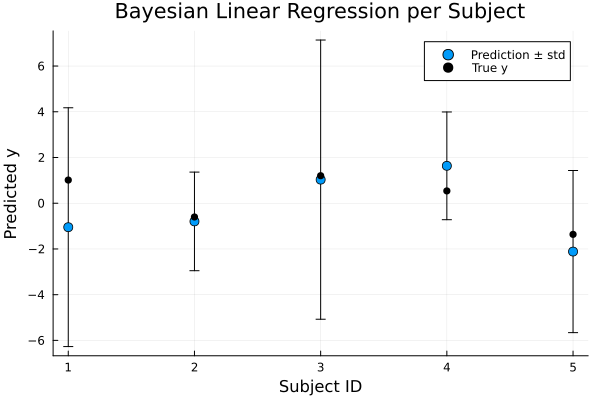

In [23]:
scatter(
    subject_ids,
    collect(y_pred_mean),
    yerror=collect(y_pred_std),
    xlabel = "Subject ID",
    ylabel = "Predicted y",
    title = "Bayesian Linear Regression per Subject",
    label = "Prediction ± std",
    legend = :topright,
    markersize = 5
)
# Overlay true y values
scatter!(
    subject_ids,
    collect(y_test_std),
    label = "True y",
    color = :black,
    markersize = 4
)

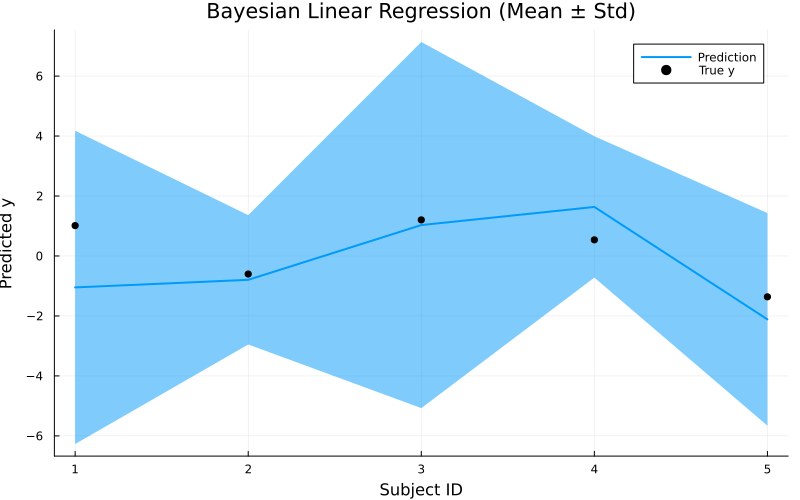

In [24]:
# Plot predicted mean with ± std ribbon
plot(
    subject_ids,
    collect(y_pred_mean),
    ribbon = collect(y_pred_std),
    xlabel = "Subject ID",
    ylabel = "Predicted y",
    title = "Bayesian Linear Regression (Mean ± Std)",
    label = "Prediction",
    linewidth = 2,
    legend = :topright,
    size = (800, 500)  # ⬅️ increased size for better y-axis resolution
)

# Overlay true y values
scatter!(
    subject_ids,
    collect(y_test_std),
    label = "True y",
    color = :black,
    markersize = 4
)

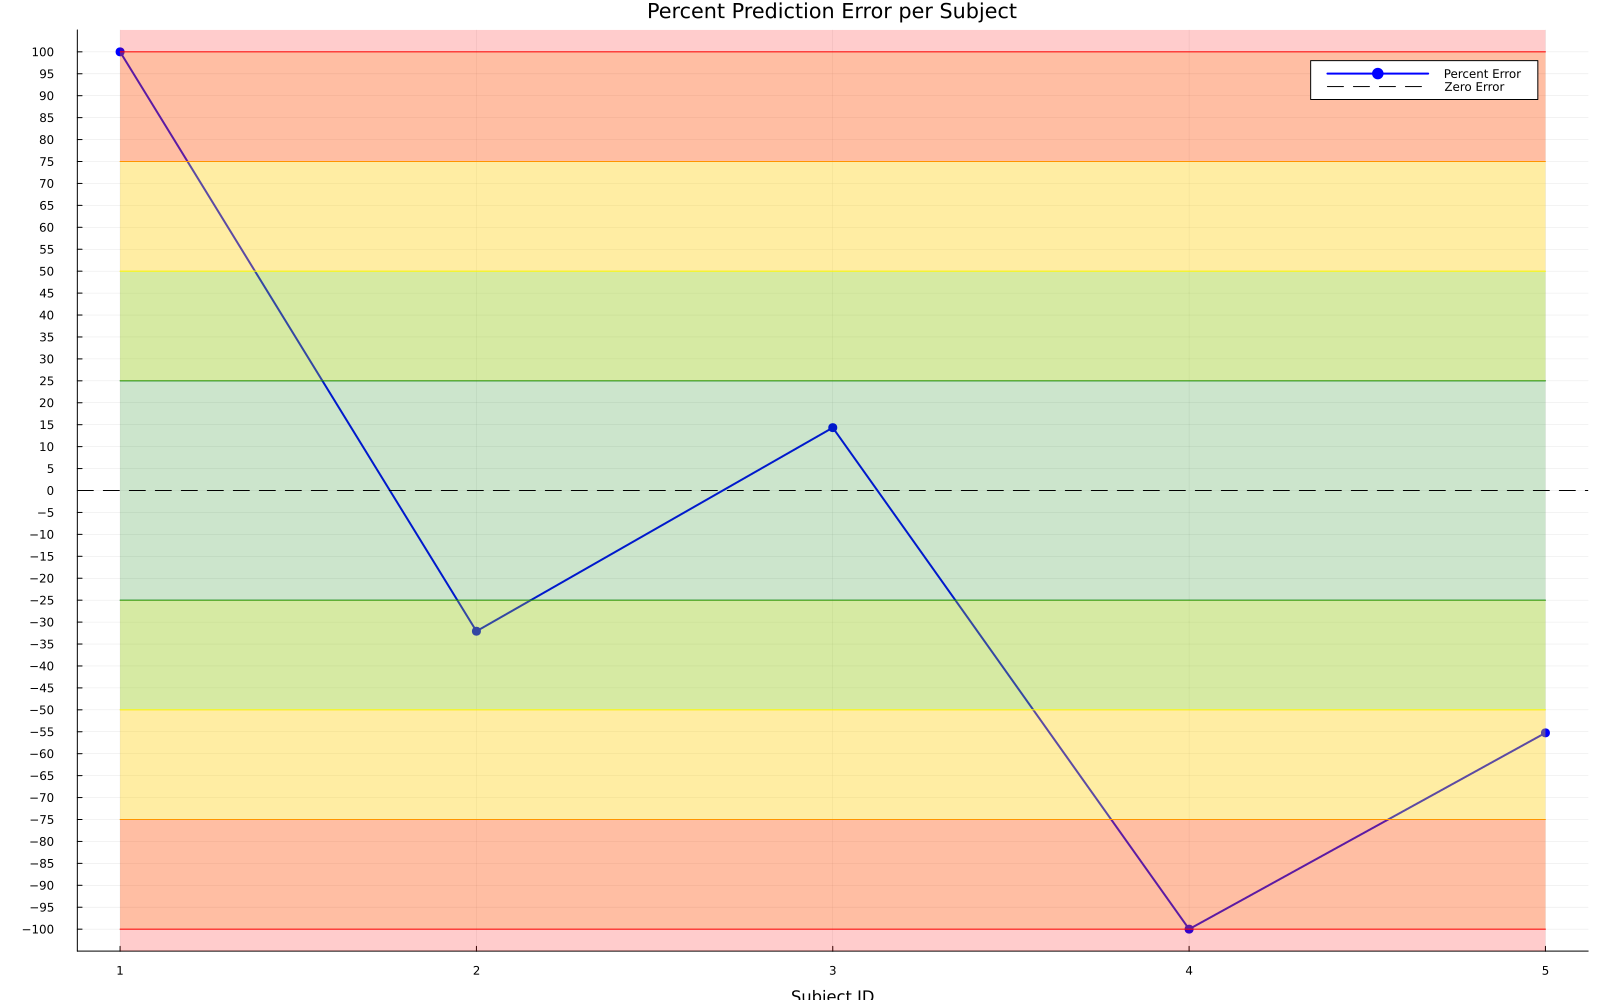

In [25]:
# Step 1: Calculate percent error and cap to ±100%
raw_errors = (collect(y_test_std) .- collect(y_pred_mean)) ./ (collect(y_test_std) .+ eps()) .* 100
residuals = clamp.(raw_errors, -100, 100)  # Cap to ±100%
subject_ids = 1:length(residuals)

# Step 2: Define band edges and matching colors
band_edges = [0, 25, 50, 75, 100]
band_colors = [:green, :yellow, :orange, :red, :purple]

# Step 3: Plot the percent error as a line with markers
plot(
    subject_ids,
    residuals,
    seriestype = :line,
    xlabel = "Subject ID",
    ylabel = "Percent Error (%)",
    title = "Percent Prediction Error per Subject",
    label = "Percent Error",
    legend = :topright,
    color = :blue,
    linewidth = 2,
    markershape = :circle,
    markersize = 5,
    markerstrokewidth = 0,
    size = (1600, 1000),
    ylim = (-105, 105),         # Ensure visibility for ±100% bands
    yticks = -100:5:100         # Y-axis ticks every 5%
)

# Step 4: Add symmetrical error bands
for i in 1:(length(band_edges)-1)
    lo, hi = band_edges[i], band_edges[i+1]
    color = band_colors[i]
    band_x = [1, length(residuals)]

    # Upper band
    plot!(
        band_x,
        fill(hi, 2),
        ribbon = fill(hi - lo, 2),
        fillalpha = 0.2,
        color = color,
        label = ""
    )

    # Lower mirrored band
    plot!(
        band_x,
        fill(-hi, 2),
        ribbon = fill(hi - lo, 2),
        fillalpha = 0.2,
        color = color,
        label = ""
    )
end

# Step 5: Add horizontal zero-error line
hline!([0], linestyle = :dash, color = :black, label = "Zero Error")

In [26]:
 @model function bayesian_cubic_model(X, y)
    n, d = size(X)

    # Priors for linear, quadratic, cubic terms
    w       ~ MvNormal(zeros(d), 1.0)       # linear
    w_quad  ~ MvNormal(zeros(d), 1.0)       # quadratic
    w_cubic ~ MvNormal(zeros(d), 1.0)       # cubic
    b       ~ Normal(0, 10)
    σ       ~ truncated(Normal(0, 1), 0, Inf)

    for i in 1:n
        x_i = X[i, :]
        mu = dot(w, x_i) +
             dot(w_quad, x_i .^ 2) +
             dot(w_cubic, x_i .^ 3) + b
        y[i] ~ Normal(mu, σ)
    end
end

bayesian_cubic_model (generic function with 2 methods)

In [27]:
model = bayesian_cubic_model(X_train_std, y_train_std)
chain = sample(model, NUTS(0.9), 10000, chain=4)

┌ Info: Found initial step size
└   ϵ = 0.0015625
Sampling: 100%|█████████████████████████████████████████| Time: 0:03:07


Chains MCMC chain (10000×65×1 Array{Float64, 3}):

Iterations        = 1001:1:11000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 191.1 seconds
Compute duration  = 191.1 seconds
parameters        = w[1], w[2], w[3], w[4], w[5], w[6], w[7], w[8], w[9], w[10], w[11], w[12], w[13], w[14], w[15], w[16], w[17], w_quad[1], w_quad[2], w_quad[3], w_quad[4], w_quad[5], w_quad[6], w_quad[7], w_quad[8], w_quad[9], w_quad[10], w_quad[11], w_quad[12], w_quad[13], w_quad[14], w_quad[15], w_quad[16], w_quad[17], w_cubic[1], w_cubic[2], w_cubic[3], w_cubic[4], w_cubic[5], w_cubic[6], w_cubic[7], w_cubic[8], w_cubic[9], w_cubic[10], w_cubic[11], w_cubic[12], w_cubic[13], w_cubic[14], w_cubic[15], w_cubic[16], w_cubic[17], b, σ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std  

In [28]:
function predict_cubic(chain, X)
    d = size(X, 2)
    n_samples = length(chain[:b])
    n_test = size(X, 1)

    w       = hcat([chain[Symbol("w[$i]")] for i in 1:d]...)
    w_quad  = hcat([chain[Symbol("w_quad[$i]")] for i in 1:d]...)
    w_cubic = hcat([chain[Symbol("w_cubic[$i]")] for i in 1:d]...)
    b       = chain[:b]

    preds = zeros(n_test, n_samples)
    for i in 1:n_samples
        ŷ = X * w[i, :] .+
             (X .^ 2) * w_quad[i, :] .+
             (X .^ 3) * w_cubic[i, :] .+
             b[i]
        preds[:, i] = ŷ
    end

    y_mean = mean(preds, dims=2)
    y_std  = std(preds, dims=2)
    return vec(y_mean), vec(y_std)
end

predict_cubic (generic function with 1 method)

In [29]:
y_pred_mean, y_pred_std = predict_cubic(chain, X_test_std)

([0.4077824801799612, -0.4731563741754245, 0.7374356467676809, 0.3205580980291528, -1.6182031888463209], [8.555101996193109, 3.658156591223557, 12.020845852975949, 4.403141246222138, 5.500069901369164])

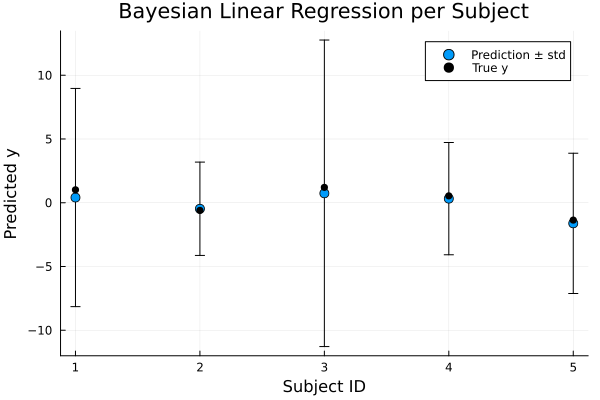

In [30]:
scatter(
    subject_ids,
    collect(y_pred_mean),
    yerror=collect(y_pred_std),
    xlabel = "Subject ID",
    ylabel = "Predicted y",
    title = "Bayesian Linear Regression per Subject",
    label = "Prediction ± std",
    legend = :topright,
    markersize = 5
)
# Overlay true y values
scatter!(
    subject_ids,
    collect(y_test_std),
    label = "True y",
    color = :black,
    markersize = 4
)

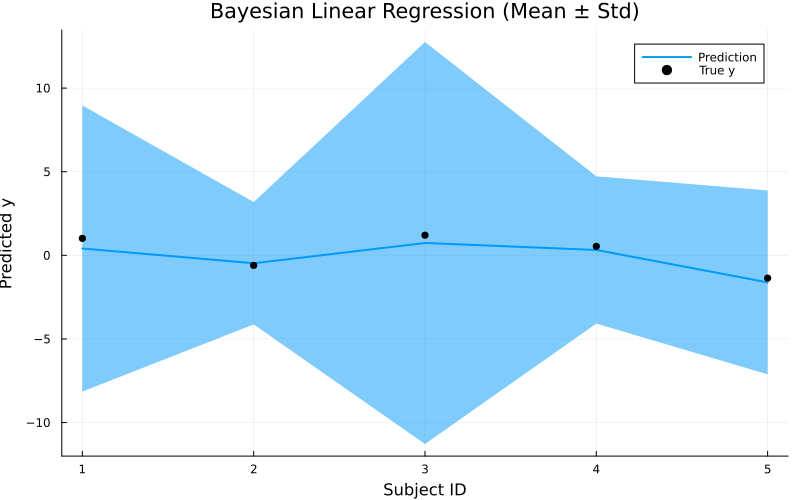

In [31]:
# Plot predicted mean with ± std ribbon
plot(
    subject_ids,
    collect(y_pred_mean),
    ribbon = collect(y_pred_std),
    xlabel = "Subject ID",
    ylabel = "Predicted y",
    title = "Bayesian Linear Regression (Mean ± Std)",
    label = "Prediction",
    linewidth = 2,
    legend = :topright,
    size = (800, 500)  # ⬅️ increased size for better y-axis resolution
)

# Overlay true y values
scatter!(
    subject_ids,
    collect(y_test_std),
    label = "True y",
    color = :black,
    markersize = 4
)

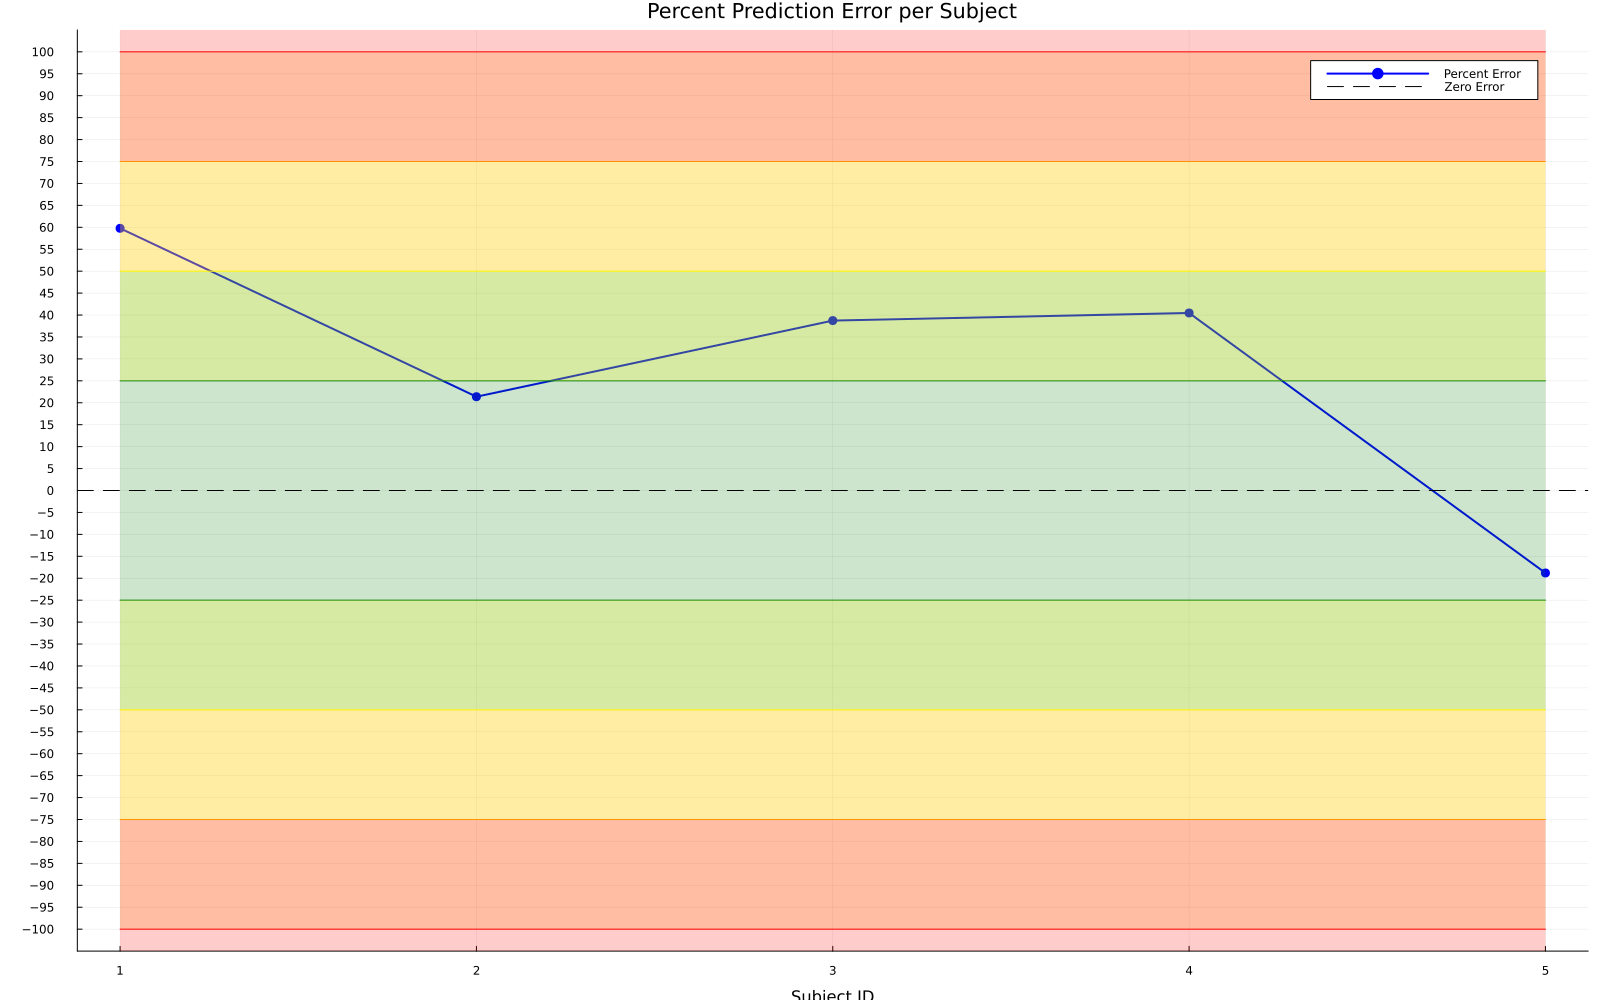

In [32]:
# Step 1: Calculate percent error and cap to ±100%
raw_errors = (collect(y_test_std) .- collect(y_pred_mean)) ./ (collect(y_test_std) .+ eps()) .* 100
residuals = clamp.(raw_errors, -100, 100)  # Cap to ±100%
subject_ids = 1:length(residuals)

# Step 2: Define band edges and matching colors
band_edges = [0, 25, 50, 75, 100]
band_colors = [:green, :yellow, :orange, :red, :purple]

# Step 3: Plot the percent error as a line with markers
plot(
    subject_ids,
    residuals,
    seriestype = :line,
    xlabel = "Subject ID",
    ylabel = "Percent Error (%)",
    title = "Percent Prediction Error per Subject",
    label = "Percent Error",
    legend = :topright,
    color = :blue,
    linewidth = 2,
    markershape = :circle,
    markersize = 5,
    markerstrokewidth = 0,
    size = (1600, 1000),
    ylim = (-105, 105),         # Ensure visibility for ±100% bands
    yticks = -100:5:100         # Y-axis ticks every 5%
)

# Step 4: Add symmetrical error bands
for i in 1:(length(band_edges)-1)
    lo, hi = band_edges[i], band_edges[i+1]
    color = band_colors[i]
    band_x = [1, length(residuals)]

    # Upper band
    plot!(
        band_x,
        fill(hi, 2),
        ribbon = fill(hi - lo, 2),
        fillalpha = 0.2,
        color = color,
        label = ""
    )

    # Lower mirrored band
    plot!(
        band_x,
        fill(-hi, 2),
        ribbon = fill(hi - lo, 2),
        fillalpha = 0.2,
        color = color,
        label = ""
    )
end

# Step 5: Add horizontal zero-error line
hline!([0], linestyle = :dash, color = :black, label = "Zero Error")

In [33]:
@model function bayesian_polynomial_model(X, y, p::Int)
    n, d = size(X)

    # Explicitly declare each weights[k] ~ MvNormal
    weights = Vector{Vector{Real}}(undef, p)
    for k in 1:p
        weights[k] ~ MvNormal(zeros(d), 1.0)
    end

    b ~ Normal(0, 10)
    σ ~ truncated(Normal(0, 1), 0, Inf)

    for i in 1:n
        x_i = X[i, :]
        mu = b
        for k in 1:p
            mu += dot(weights[k], x_i .^ k)
        end
        y[i] ~ Normal(mu, σ)
    end
end

bayesian_polynomial_model (generic function with 2 methods)

In [34]:
p = 4  # 4th order
model = bayesian_polynomial_model(X_train_std, y_train_std, p)
chain = sample(model, NUTS(0.9), 10000, chain=4)

┌ Info: Found initial step size
└   ϵ = 0.0015625
Sampling: 100%|█████████████████████████████████████████| Time: 0:05:15


Chains MCMC chain (10000×82×1 Array{Float64, 3}):

Iterations        = 1001:1:11000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 320.32 seconds
Compute duration  = 320.32 seconds
parameters        = weights[1][1], weights[1][2], weights[1][3], weights[1][4], weights[1][5], weights[1][6], weights[1][7], weights[1][8], weights[1][9], weights[1][10], weights[1][11], weights[1][12], weights[1][13], weights[1][14], weights[1][15], weights[1][16], weights[1][17], weights[2][1], weights[2][2], weights[2][3], weights[2][4], weights[2][5], weights[2][6], weights[2][7], weights[2][8], weights[2][9], weights[2][10], weights[2][11], weights[2][12], weights[2][13], weights[2][14], weights[2][15], weights[2][16], weights[2][17], weights[3][1], weights[3][2], weights[3][3], weights[3][4], weights[3][5], weights[3][6], weights[3][7], weights[3][8], weights[3][9], weights[3][10], weights[3][11], weights[3][12], weights[3][13], weights[3][14], weights[3][15], weights[3][16], weigh

In [35]:
function predict_polynomial(chain, X, p::Int)
    d = size(X, 2)
    n_samples = length(chain[:b])
    n_test = size(X, 1)
    preds = zeros(n_test, n_samples)

    for i in 1:n_samples
        mu = zeros(n_test)
        for k in 1:p
            w_k = hcat([chain[Symbol("weights[$k][$j]")] for j in 1:d]...)
            mu .+= (X .^ k) * w_k[i, :]
        end
        mu .+= chain[:b][i]
        preds[:, i] = mu
    end

    y_mean = mean(preds, dims=2)
    y_std = std(preds, dims=2)
    return vec(y_mean), vec(y_std)
end

predict_polynomial (generic function with 1 method)

In [36]:
y_pred_mean, y_pred_std = predict_polynomial(chain, X_test_std,4)

([-2.3814933220496872, -0.30551832667171436, 1.0672501905696516, -0.025753896949475073, -2.0319727269145105], [18.88482013457217, 4.884829126267492, 30.62301052152222, 7.680204009146467, 8.47363397422282])

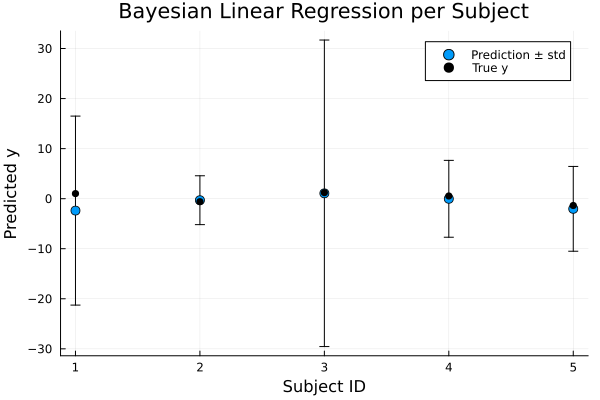

In [37]:
scatter(
    subject_ids,
    collect(y_pred_mean),
    yerror=collect(y_pred_std),
    xlabel = "Subject ID",
    ylabel = "Predicted y",
    title = "Bayesian Linear Regression per Subject",
    label = "Prediction ± std",
    legend = :topright,
    markersize = 5
)

# Overlay true y values
scatter!(
    subject_ids,
    collect(y_test_std),
    label = "True y",
    color = :black,
    markersize = 4
)

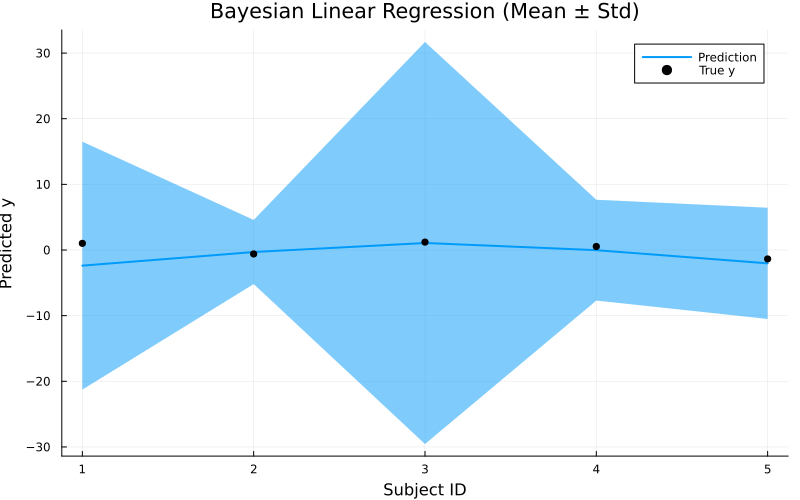

In [39]:
# Plot predicted mean with ± std ribbon
plot(
    subject_ids,
    collect(y_pred_mean),
    ribbon = collect(y_pred_std),
    xlabel = "Subject ID",
    ylabel = "Predicted y",
    title = "Bayesian Linear Regression (Mean ± Std)",
    label = "Prediction",
    linewidth = 2,
    legend = :topright,
    size = (800, 500)  # ⬅️ increased size for better y-axis resolution
)

# Overlay true y values
scatter!(
    subject_ids,
    collect(y_test_std),
    label = "True y",
    color = :black,
    markersize = 4
)

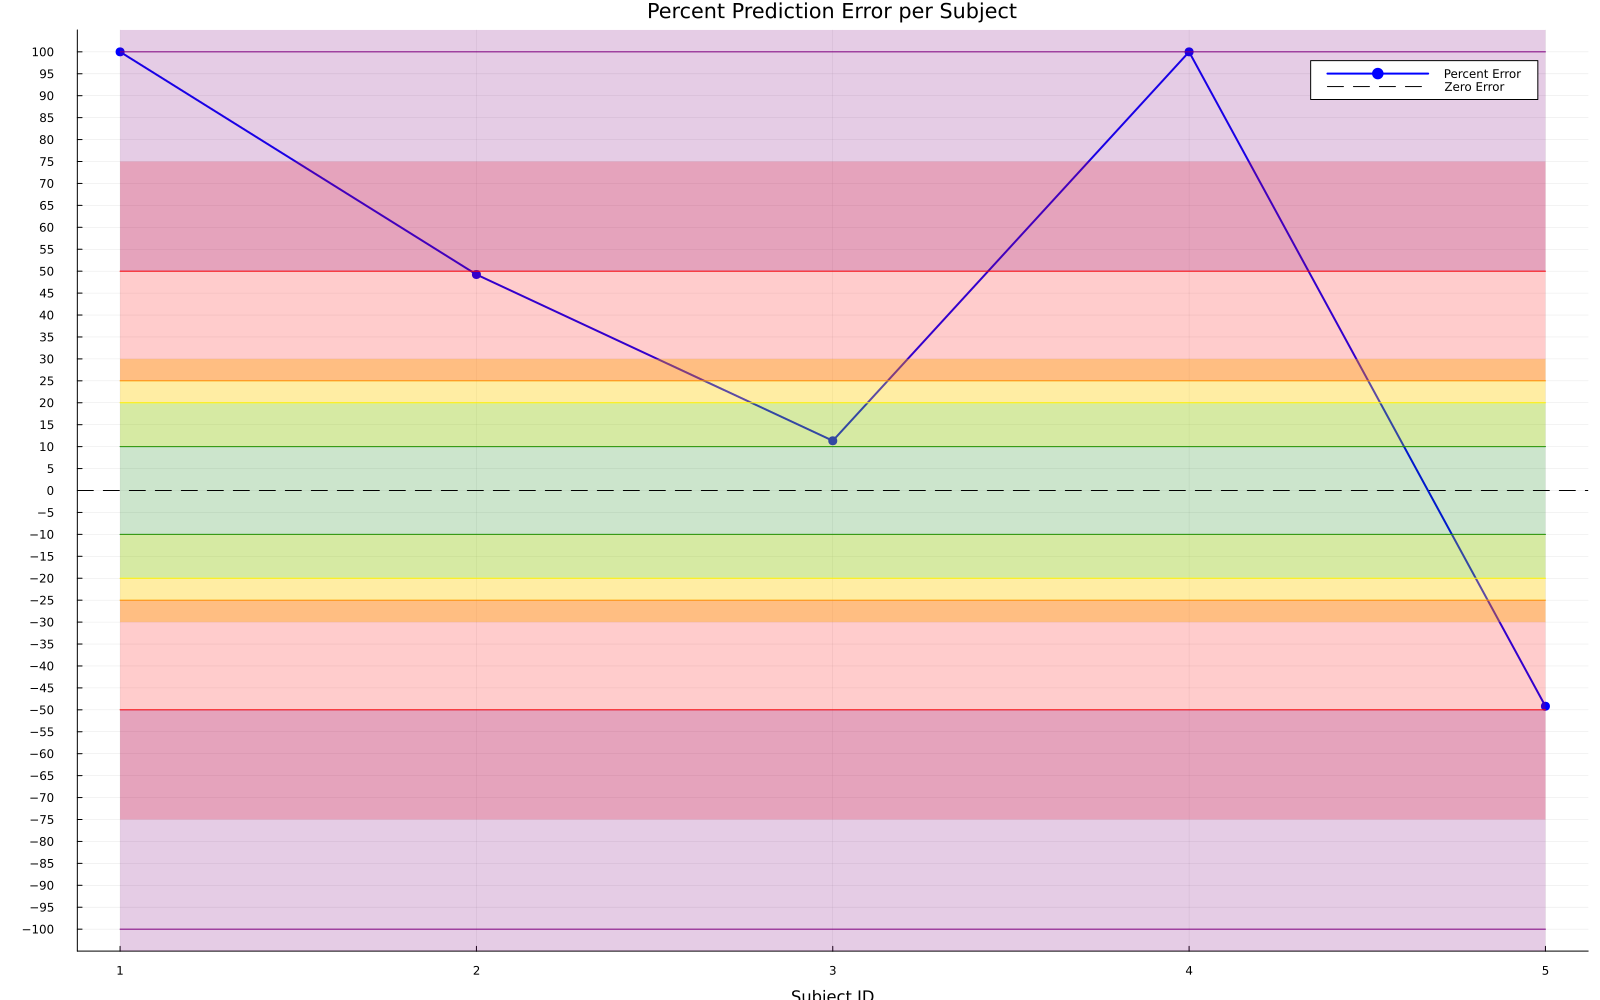

In [40]:
# Step 1: Calculate percent error and cap to ±100%
raw_errors = (collect(y_test_std) .- collect(y_pred_mean)) ./ (collect(y_test_std) .+ eps()) .* 100
residuals = clamp.(raw_errors, -100, 100)  # Cap to ±100%
subject_ids = 1:length(residuals)

# Step 2: Define band edges and matching colors
band_edges = [0, 10, 20, 25, 50, 100]
band_colors = [:green, :yellow, :orange, :red, :purple, :brown]

# Step 3: Plot the percent error as a line with markers
plot(
    subject_ids,
    residuals,
    seriestype = :line,
    xlabel = "Subject ID",
    ylabel = "Percent Error (%)",
    title = "Percent Prediction Error per Subject",
    label = "Percent Error",
    legend = :topright,
    color = :blue,
    linewidth = 2,
    markershape = :circle,
    markersize = 5,
    markerstrokewidth = 0,
    size = (1600, 1000),
    ylim = (-105, 105),         # Ensure visibility for ±100% bands
    yticks = -100:5:100         # Y-axis ticks every 5%
)

# Step 4: Add symmetrical error bands
for i in 1:(length(band_edges)-1)
    lo, hi = band_edges[i], band_edges[i+1]
    color = band_colors[i]
    band_x = [1, length(residuals)]

    # Upper band
    plot!(
        band_x,
        fill(hi, 2),
        ribbon = fill(hi - lo, 2),
        fillalpha = 0.2,
        color = color,
        label = ""
    )

    # Lower mirrored band
    plot!(
        band_x,
        fill(-hi, 2),
        ribbon = fill(hi - lo, 2),
        fillalpha = 0.2,
        color = color,
        label = ""
    )
end

# Step 5: Add horizontal zero-error line
hline!([0], linestyle = :dash, color = :black, label = "Zero Error")

In [41]:
p = 5  # 5th order
model = bayesian_polynomial_model(X_train_std, y_train_std, p)
chain = sample(model, NUTS(0.9), 10000, chain=5)

┌ Info: Found initial step size
└   ϵ = 0.0125
Sampling: 100%|█████████████████████████████████████████| Time: 0:30:02


Chains MCMC chain (10000×99×1 Array{Float64, 3}):

Iterations        = 1001:1:11000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 1811.4 seconds
Compute duration  = 1811.4 seconds
parameters        = weights[1][1], weights[1][2], weights[1][3], weights[1][4], weights[1][5], weights[1][6], weights[1][7], weights[1][8], weights[1][9], weights[1][10], weights[1][11], weights[1][12], weights[1][13], weights[1][14], weights[1][15], weights[1][16], weights[1][17], weights[2][1], weights[2][2], weights[2][3], weights[2][4], weights[2][5], weights[2][6], weights[2][7], weights[2][8], weights[2][9], weights[2][10], weights[2][11], weights[2][12], weights[2][13], weights[2][14], weights[2][15], weights[2][16], weights[2][17], weights[3][1], weights[3][2], weights[3][3], weights[3][4], weights[3][5], weights[3][6], weights[3][7], weights[3][8], weights[3][9], weights[3][10], weights[3][11], weights[3][12], weights[3][13], weights[3][14], weights[3][15], weights[3][16], weigh

In [42]:
y_pred_mean, y_pred_std = predict_polynomial(chain, X_test_std,5)

([0.34457397956276326, -0.4098557987738599, -0.3175370493790672, 0.31342619261094157, -1.3763637673240274], [34.02221137659755, 8.318693731876412, 68.19353348592865, 12.144435074785024, 13.69016671192647])

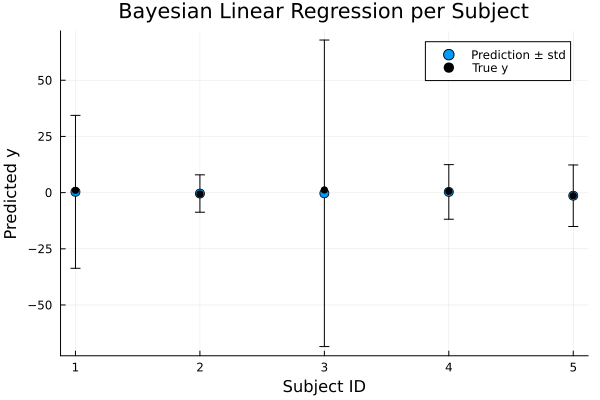

In [43]:
scatter(
    subject_ids,
    collect(y_pred_mean),
    yerror=collect(y_pred_std),
    xlabel = "Subject ID",
    ylabel = "Predicted y",
    title = "Bayesian Linear Regression per Subject",
    label = "Prediction ± std",
    legend = :topright,
    markersize = 5
)

# Overlay true y values
scatter!(
    subject_ids,
    collect(y_test_std),
    label = "True y",
    color = :black,
    markersize = 4
)

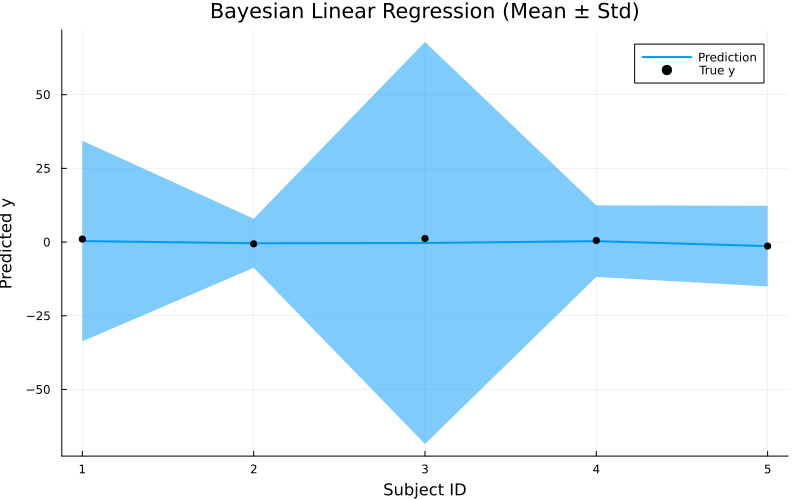

In [44]:
# Plot predicted mean with ± std ribbon
plot(
    subject_ids,
    collect(y_pred_mean),
    ribbon = collect(y_pred_std),
    xlabel = "Subject ID",
    ylabel = "Predicted y",
    title = "Bayesian Linear Regression (Mean ± Std)",
    label = "Prediction",
    linewidth = 2,
    legend = :topright,
    size = (800, 500)  # ⬅️ increased size for better y-axis resolution
)

# Overlay true y values
scatter!(
    subject_ids,
    collect(y_test_std),
    label = "True y",
    color = :black,
    markersize = 4
)

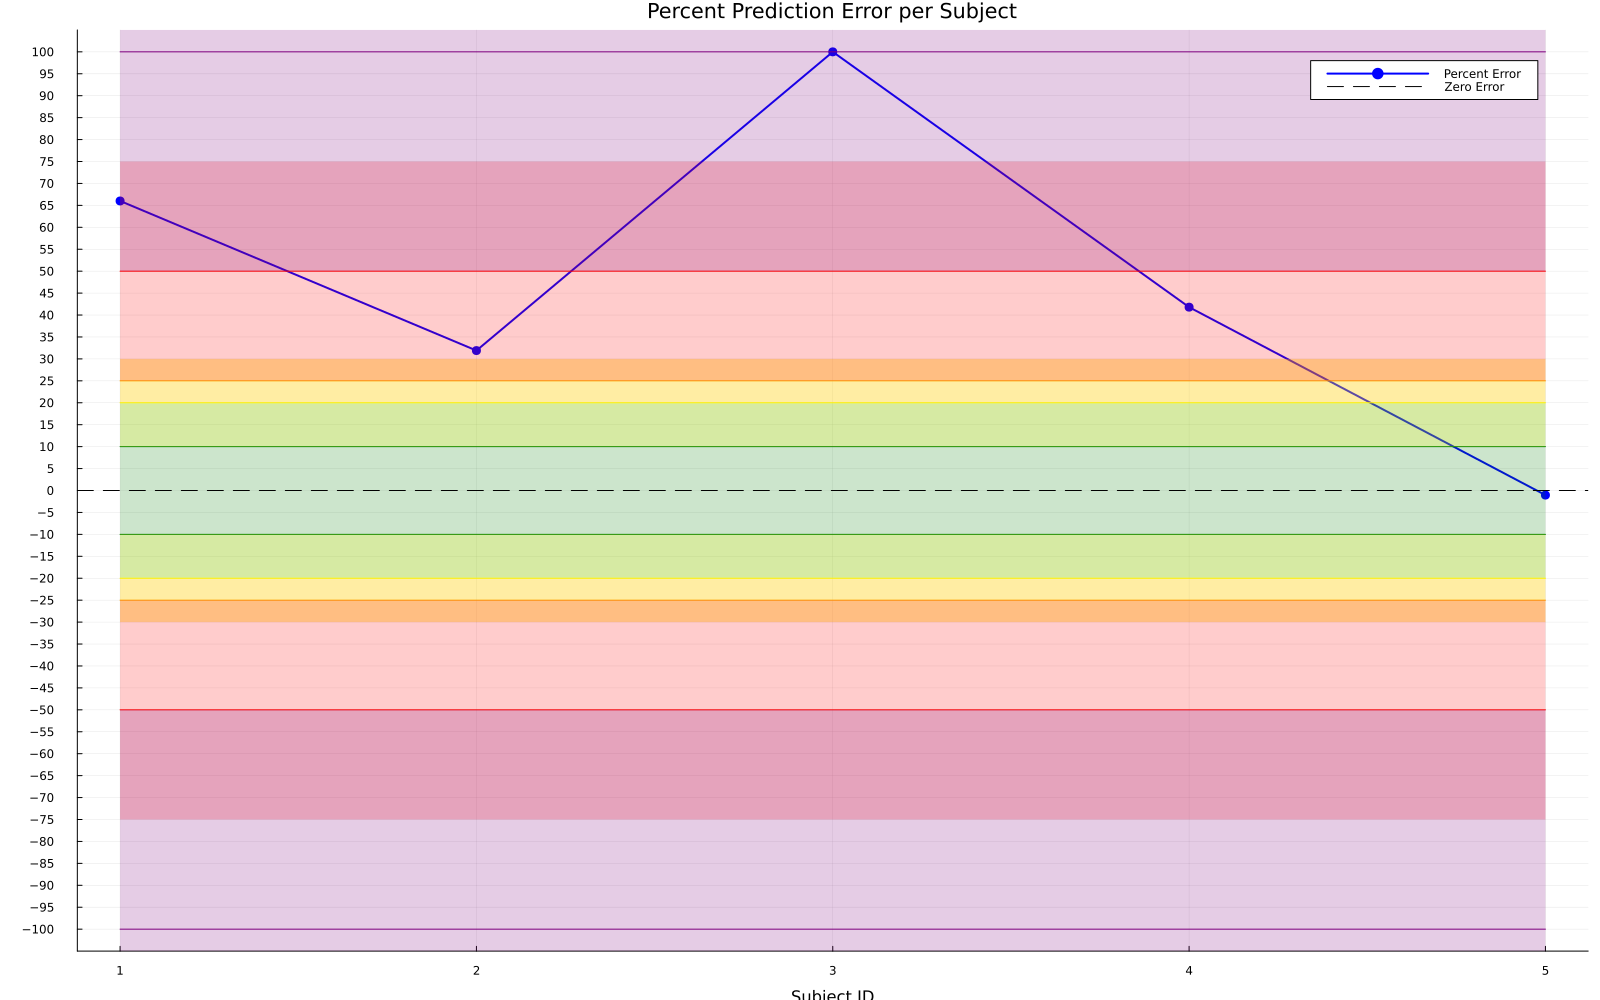

In [45]:
# Step 1: Calculate percent error and cap to ±100%
raw_errors = (collect(y_test_std) .- collect(y_pred_mean)) ./ (collect(y_test_std) .+ eps()) .* 100
residuals = clamp.(raw_errors, -100, 100)  # Cap to ±100%
subject_ids = 1:length(residuals)

# Step 2: Define band edges and matching colors
band_edges = [0, 10, 20, 25, 50, 100]
band_colors = [:green, :yellow, :orange, :red, :purple, :brown]

# Step 3: Plot the percent error as a line with markers
plot(
    subject_ids,
    residuals,
    seriestype = :line,
    xlabel = "Subject ID",
    ylabel = "Percent Error (%)",
    title = "Percent Prediction Error per Subject",
    label = "Percent Error",
    legend = :topright,
    color = :blue,
    linewidth = 2,
    markershape = :circle,
    markersize = 5,
    markerstrokewidth = 0,
    size = (1600, 1000),
    ylim = (-105, 105),         # Ensure visibility for ±100% bands
    yticks = -100:5:100         # Y-axis ticks every 5%
)

# Step 4: Add symmetrical error bands
for i in 1:(length(band_edges)-1)
    lo, hi = band_edges[i], band_edges[i+1]
    color = band_colors[i]
    band_x = [1, length(residuals)]

    # Upper band
    plot!(
        band_x,
        fill(hi, 2),
        ribbon = fill(hi - lo, 2),
        fillalpha = 0.2,
        color = color,
        label = ""
    )

    # Lower mirrored band
    plot!(
        band_x,
        fill(-hi, 2),
        ribbon = fill(hi - lo, 2),
        fillalpha = 0.2,
        color = color,
        label = ""
    )
end

# Step 5: Add horizontal zero-error line
hline!([0], linestyle = :dash, color = :black, label = "Zero Error")